In [1]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pandas.read_csv("https://meils3.s3.amazonaws.com/forestfires.csv")
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


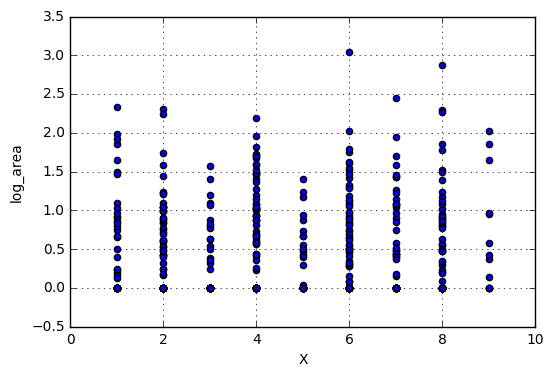

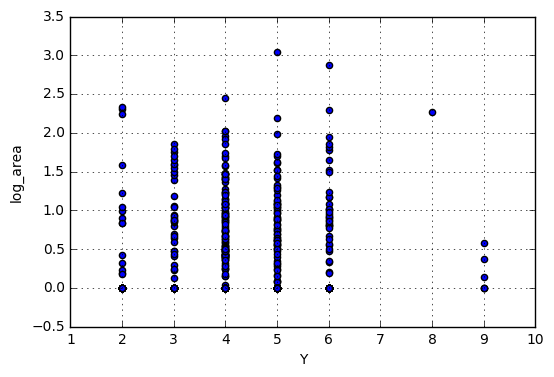

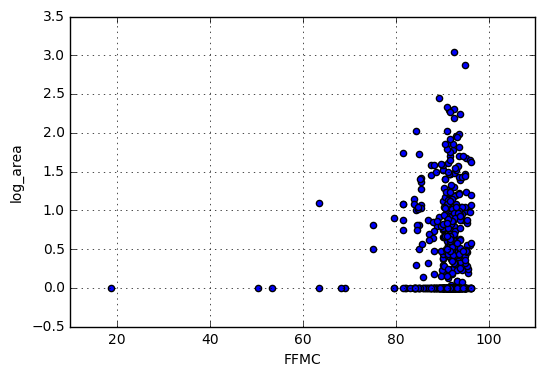

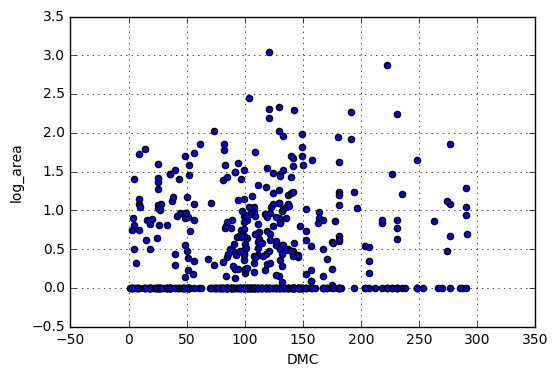

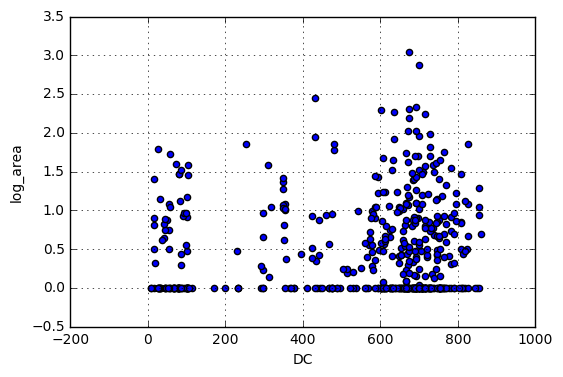

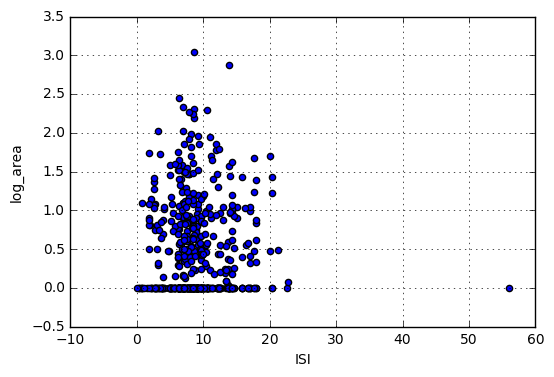

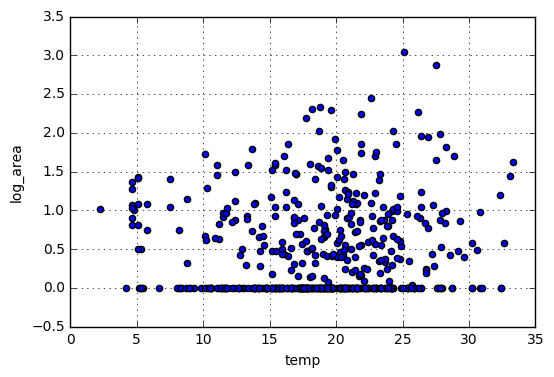

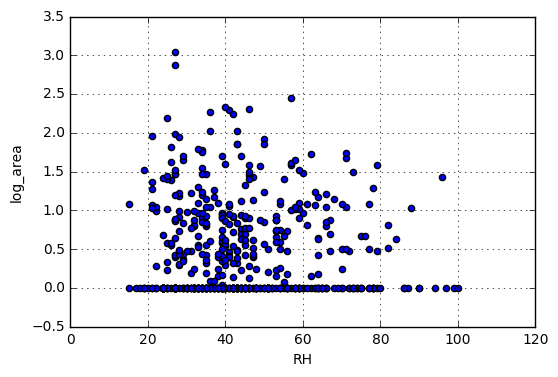

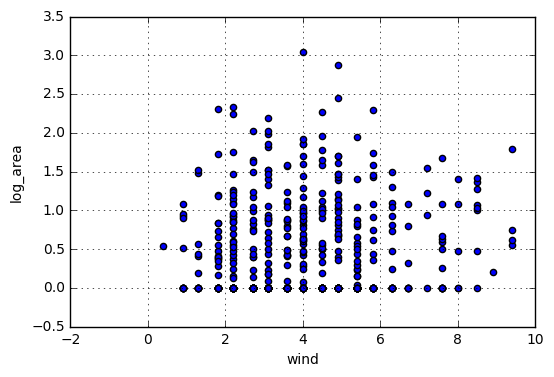

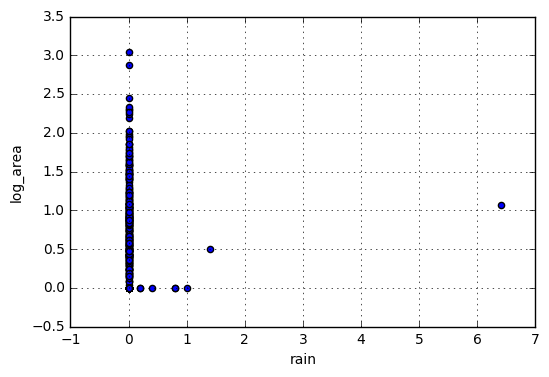

In [4]:
data['log_area']=np.log10(data['area']+1)
for i in data.describe().columns[:-2]:
    data.plot.scatter(i, 'log_area', grid=True)
    plt.show()

### Scatter plots containing two variables: explained variable and a series of explanatory variables could provide us idea how to build a particular model.

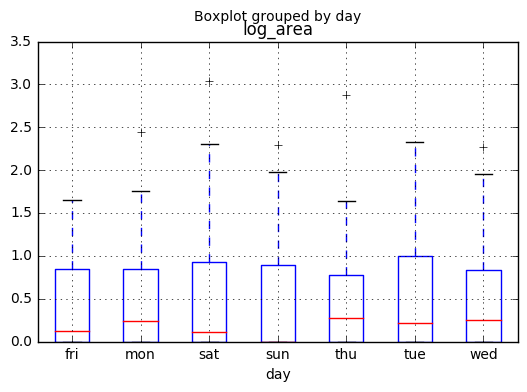

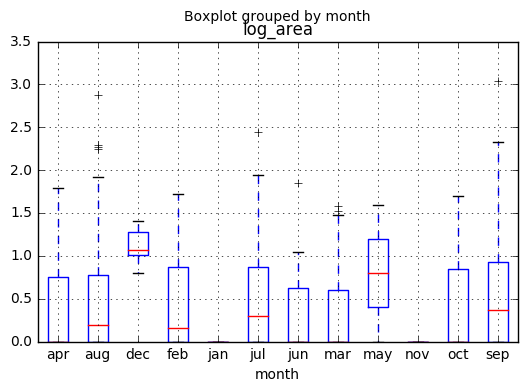

In [5]:
data.boxplot(column='log_area',by='day')
data.boxplot(column='log_area',by='month')
plt.show()

### Those two bar plots provides information on how the particular day or month affected the value of area burned (logarithmic function). According to the plot at the top the highest median (red line) is for Monday or Wednesday with the highest value of third quartile for Saturday or Tuesday.

### Regarding barplot for months undoubtedly highest values of burned area are reached for December and May.

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(data['month'])
enc.classes_


array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep'], dtype=object)

In [7]:
data["month_number"]=enc.transform(data["month"])
data.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,month_number
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,7
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,10
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,10


In [8]:
enc.fit(data['day'])
enc.classes_

array(['fri', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed'], dtype=object)

In [9]:
data["day_number"]=enc.transform(data["day"])
data.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,month_number,day_number
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,7,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,10,5
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,10,2


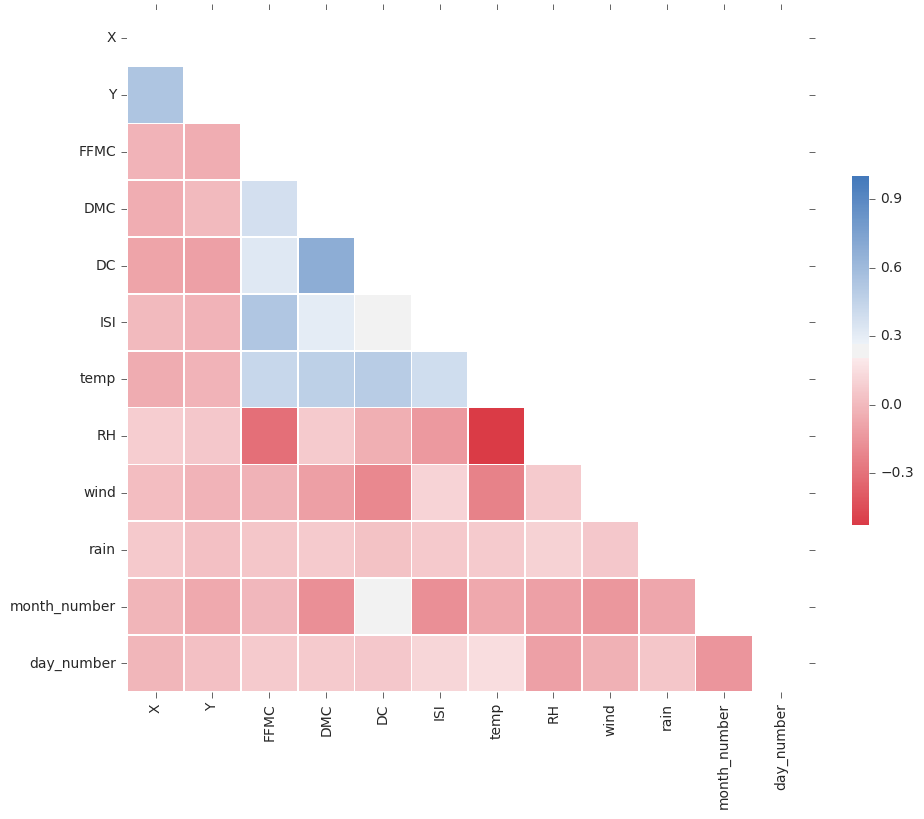

In [33]:
corr = data.drop(['area','log_area','month','day'],axis=1).corr()
corr

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set_style(style = 'white')

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(10, 250, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.show()

### Correlation heat map provides useful information while preparing inputs for the ML model. Nevertheless in this case we use almost all variables as inputs.

In [11]:
from sklearn.model_selection import train_test_split

X_data=data.drop(['area','log_area','month','day'],axis=1)
Y_data=data['log_area']
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,test_size = 0.35, random_state=42)
y_train=y_train.reshape(y_train.size,1)

## Regression Error Characteristic (REC)

In [12]:
def rec(m,n,tol):
    if type(m)!='numpy.ndarray':
        m=np.array(m)
    if type(n)!='numpy.ndarray':
        n=np.array(n)
    l=m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)

tolerance_max=20

## Support Vector Regressor (SVR) using GridSearch

In [13]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [14]:
scaler=StandardScaler()

In [15]:
param_grid = {'C': [0.01,0.1,1, 10], 'epsilon': [10,1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

In [17]:
print("Best parameters obtained by Grid Search:",grid_SVR.best_params_)

Best parameters obtained by Grid Search: {'kernel': 'rbf', 'C': 0.01, 'epsilon': 1}


In [ ]:
grid_SVR = GridSearchCV(SVR(),param_grid,refit=True,verbose=0,cv=5)
grid_SVR.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))

In [18]:
y_predicted=grid_SVR.predict(X_test)
print("RMSE for Support Vector Regression:",np.sqrt(np.mean((y_test-y_predicted)**2)))

RMSE for Support Vector Regression: 0.701873022613


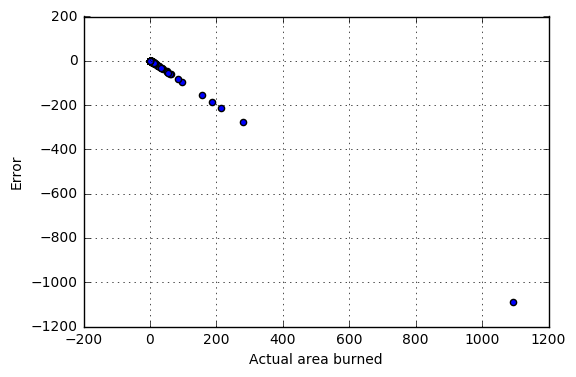

In [19]:
plt.xlabel("Actual area burned")
plt.ylabel("Error")
plt.grid(True)
plt.scatter(10**(y_test),10**(y_predicted)-10**(y_test))
plt.show()

### Scatter plot including error (Y axis) and area burned (X axis) provides qualitative and quantitative information of the prediction model.

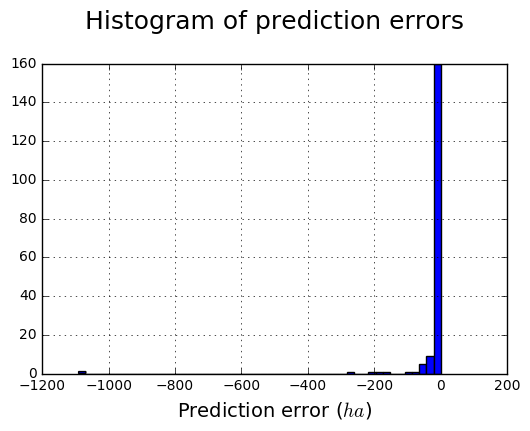

In [20]:
plt.title("Histogram of prediction errors\n",fontsize=18)
plt.xlabel("Prediction error ($ha$)",fontsize=14)
plt.grid(True)
plt.hist(10**(y_predicted.reshape(y_predicted.size,))-10**(y_test),bins=50)
plt.show()

### Histogram od prediction errors shows the amount of values predicted with particular error [ha]. We can see that most of them is in the range from -300 to 0 but there is also an outlier(s) with value of around -1100.

In [21]:
rec_SVR=[]
for i in range(tolerance_max):
    rec_SVR.append(rec(y_predicted,y_test,i))


## Random Forest Regressor


In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
param_grid = {'max_depth': [5,10,15,20,50], 'max_leaf_nodes': [2,5,10], 'min_samples_leaf': [2,5,10],
             'min_samples_split':[2,5,10]}
grid_RF = GridSearchCV(RandomForestRegressor(),param_grid,refit=True,verbose=0,cv=5)
grid_RF.fit(X_train,y_train.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [2, 5, 10], 'min_samples_split': [2, 5, 10], 'max_leaf_nodes': [2, 5, 10], 'max_depth': [5, 10, 15, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
print("Best parameters obtained by Grid Search:",grid_RF.best_params_)

Best parameters obtained by Grid Search: {'min_samples_leaf': 2, 'min_samples_split': 5, 'max_leaf_nodes': 2, 'max_depth': 15}


In [25]:
y_predicted = grid_RF.predict(X_test)
rmse_rf=np.sqrt(np.mean((y_test-y_predicted)**2))
print("RMSE for Random Forest:",rmse_rf)

RMSE for Random Forest: 0.633984087748


In [26]:
rec_RF=[]
for i in range(tolerance_max):
    rec_RF.append(rec(y_predicted,y_test,i))

## Decision Tree Regressor

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
tree_model = DecisionTreeRegressor(max_depth=10,criterion='mae')
tree_model.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))

DecisionTreeRegressor(criterion='mae', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [29]:
y_predicted=tree_model.predict(X_test)
print("RMSE for Decision Tree:",np.sqrt(np.mean((y_test-y_predicted)**2)))

rec_DT=[]
for i in range(tolerance_max):
    rec_DT.append(rec(y_predicted,y_test,i))

RMSE for Decision Tree: 0.647107861931


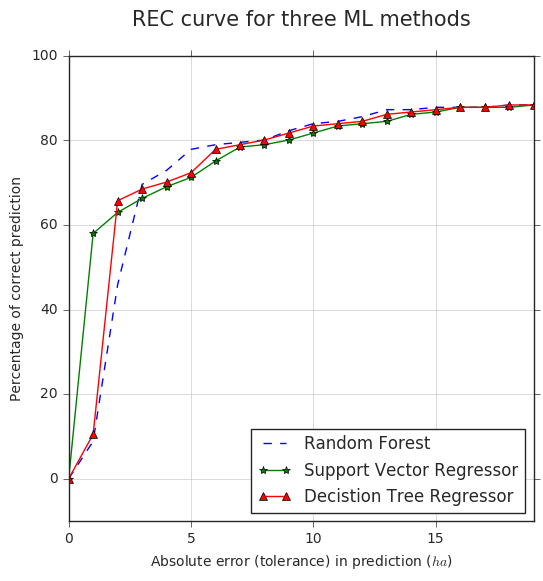

In [38]:
plt.figure(figsize=(6,6))
plt.title("REC curve for three ML methods\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tolerance_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tolerance_max),rec_RF, '--')
plt.plot(range(tolerance_max), rec_SVR, '-*')
plt.plot(range(tolerance_max), rec_DT, '-^')
plt.legend(['Random Forest', 'Support Vector Regressor', 'Decistion Tree Regressor'], fontsize=12, loc='best')
plt.show()

### According to the plot above the most efficient ML method for this case is SVR because it reaches the lowest absolute error in prediction with sligtly smaller percentage of correct prediction in test set. On the other hand RF is first method to meet the level of 80% of correct predictions. DTR is somewhere between those two.

### At the end of a day we neet to decide which factor we appreciate more - either fast closure to high percentage of correct predictions or low value of absolute error in prediction.